# Next-Frame Video Prediction with Convolutional LSTMs

**Author:** [Amogh Joshi](https://github.com/amogh7joshi)<br>
**Date created:** 2021/06/02<br>
**Last modified:** 2021/06/05<br>
**Description:** How to build and train a convolutional LSTM model for next-frame video prediction.

## Introduction

The
[Convolutional LSTM](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)
architectures bring together time series processing and computer vision by
introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the
Convolutional LSTM model in an application to next-frame prediction, the process
of predicting what video frames come next given a series of past frames.

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Dataset Construction

For this example, we will be using the
[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

We will download the dataset and then construct and
preprocess training and validation sets.

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.

In [ ]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)

In [ ]:
#
# the original dataset shape is (nf, nb, nc, nr) where
# nf = 20: number of time frames
# nb = 10000: number of samples
# nr = 64: number of data rows (depth)
# nc = 64: number of data cols (width)
#
dataset = np.load(fpath)
dataset_orig = dataset.copy()
print("dataset shape BEFORE swaping",dataset_orig.shape)
# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
print("dataset shape AFTER swaping",dataset.shape)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)
print("dataset shape AFTER expanding dim",dataset.shape)

dataset shape BEFORE swaping (20, 10000, 64, 64)
dataset shape AFTER swaping (10000, 20, 64, 64)
dataset shape AFTER expanding dim (1000, 20, 64, 64, 1)


In [ ]:
#
# Split into train and validation sets using indexing to optimize memory, using
# 90% for training and 10% for validation
#
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

print("Traing dataset shape after splitting is",train_dataset.shape)
print("Val dataset shape after splitting is",val_dataset.shape)

Traing dataset shape after splitting is (900, 20, 64, 64, 1)
Val dataset shape after splitting is (100, 20, 64, 64, 1)


In [ ]:
#
# create a time-lagged target pair (x_train,y_train) for training
#
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n. Note that this function
# will be important as it defines the lead times. Shifting 1 means 1-lead time
# ahead. Likewise, shifting k means k-lead time ahead.
#
def create_shifted_frames(data):
    print("Input for the shift function is: ",data.shape)
    x = data[:, 0 : data.shape[1] - 1, :, :, :]
    y = data[:, 1 : data.shape[1], :, :, :]
    print("After shifting produces:", x.shape,y.shape)
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))
print(train_dataset.shape,x_train.shape)

Input for the shift function is:  (900, 20, 64, 64, 1)
After shifting produces: (900, 19, 64, 64, 1) (900, 19, 64, 64, 1)
Input for the shift function is:  (100, 20, 64, 64, 1)
After shifting produces: (100, 19, 64, 64, 1) (100, 19, 64, 64, 1)
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
(900, 20, 64, 64, 1) (900, 19, 64, 64, 1)


## Data Visualization

Our data consists of sequences of frames, each of which
are used to predict the upcoming frame. Let's take a look
at some of these sequential frames.

random choice of data to be plot is:  196
Plotting figures:  196 0 Axes(0.125,0.712609;0.133621x0.167391)
Plotting figures:  196 1 Axes(0.285345,0.712609;0.133621x0.167391)
Plotting figures:  196 2 Axes(0.44569,0.712609;0.133621x0.167391)
Plotting figures:  196 3 Axes(0.606034,0.712609;0.133621x0.167391)
Plotting figures:  196 4 Axes(0.766379,0.712609;0.133621x0.167391)
Plotting figures:  196 5 Axes(0.125,0.511739;0.133621x0.167391)
Plotting figures:  196 6 Axes(0.285345,0.511739;0.133621x0.167391)
Plotting figures:  196 7 Axes(0.44569,0.511739;0.133621x0.167391)
Plotting figures:  196 8 Axes(0.606034,0.511739;0.133621x0.167391)
Plotting figures:  196 9 Axes(0.766379,0.511739;0.133621x0.167391)
Plotting figures:  196 10 Axes(0.125,0.31087;0.133621x0.167391)
Plotting figures:  196 11 Axes(0.285345,0.31087;0.133621x0.167391)
Plotting figures:  196 12 Axes(0.44569,0.31087;0.133621x0.167391)
Plotting figures:  196 13 Axes(0.606034,0.31087;0.133621x0.167391)
Plotting figures:  196 14 Axes(0

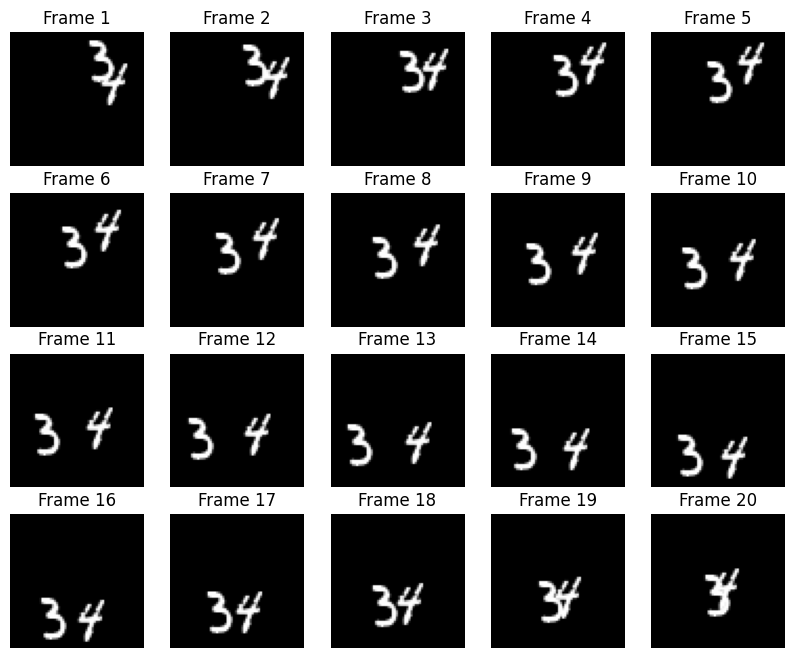

In [ ]:
#
# Construct a figure on which we will visualize the images.
#
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
print("random choice of data to be plot is: ",data_choice)
for idx, ax in enumerate(axes.flat):
    print("Plotting figures: ",data_choice,idx,ax)
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))
print("Input shape is", inp.shape)

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)
model.summary()

Input shape is (None, None, 64, 64, 1)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 64, 64, 1   0         
                             )]                                  
                                                                 
 conv_lstm2d_12 (ConvLSTM2D  (None, None, 64, 64, 64   416256    
 )                           )                                   
                                                                 
 batch_normalization_8 (Bat  (None, None, 64, 64, 64   256       
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_13 (ConvLSTM2D  (None, None, 64, 64, 64   295168    
 )                           )                                   
                                                                 
 batch_normalization

## Model Training

With our model and data constructed, we can now train the model.

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
180/180 [==============================] - 144s 711ms/step - loss: 0.0929 - val_loss: 0.2218 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 129s 719ms/step - loss: 0.0290 - val_loss: 0.1851 - lr: 0.0010
Epoch 3/20
180/180 [==============================] - 129s 719ms/step - loss: 0.0274 - val_loss: 0.1035 - lr: 0.0010
Epoch 4/20
180/180 [==============================] - 129s 718ms/step - loss: 0.0266 - val_loss: 0.0434 - lr: 0.0010
Epoch 5/20
180/180 [==============================] - 130s 720ms/step - loss: 0.0260 - val_loss: 0.0375 - lr: 0.0010
Epoch 6/20
180/180 [==============================] - 130s 720ms/step - loss: 0.0256 - val_loss: 0.0320 - lr: 0.0010
Epoch 7/20
180/180 [==============================] - 130s 720ms/step - loss: 0.0251 - val_loss: 0.0284 - lr: 0.0010
Epoch 8/20
180/180 [==============================] - 129s 718ms/step - loss: 0.0249 - val_loss: 0.0280 - lr: 0.0010
Epoch 9/20
180/180 [==============================] - 129s 718ms

In [ ]:
aaa = np.array([[[2,3,4],[5,6,7]],[[-2,-3,-4],[-5,-6,-7]]])
print(aaa[-1,...],aaa.shape)
m1 = aaa[1,:,:].flat[np.abs(aaa[1,:,:]).argmax()]
m2 = np.abs(aaa[1,:,:]).argmax()
m3 = aaa[1,:,:].flat[1]
print(m1,m2)
print(m3)

[[-2 -3 -4]
 [-5 -6 -7]] (2, 2, 3)
-7 5
-3


## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

Example sample is:  (20, 64, 64, 1) 45
Input frames and original frames shapes are:  (10, 64, 64, 1) (10, 64, 64, 1)
1/1 [==============================] - 0s 55ms/step
Output from prediction:  (1, 10, 64, 64, 1) 0
After squeezing from prediction:  (10, 64, 64, 1) 0
After expanding from prediction:  (1, 64, 64, 1) 0
1/1 [==============================] - 0s 55ms/step
Output from prediction:  (1, 11, 64, 64, 1) 1
After squeezing from prediction:  (11, 64, 64, 1) 1
After expanding from prediction:  (1, 64, 64, 1) 1
1/1 [==============================] - 0s 60ms/step
Output from prediction:  (1, 12, 64, 64, 1) 2
After squeezing from prediction:  (12, 64, 64, 1) 2
After expanding from prediction:  (1, 64, 64, 1) 2
1/1 [==============================] - 0s 64ms/step
Output from prediction:  (1, 13, 64, 64, 1) 3
After squeezing from prediction:  (13, 64, 64, 1) 3
After expanding from prediction:  (1, 64, 64, 1) 3
1/1 [==============================] - 0s 65ms/step
Output from prediction:  (1

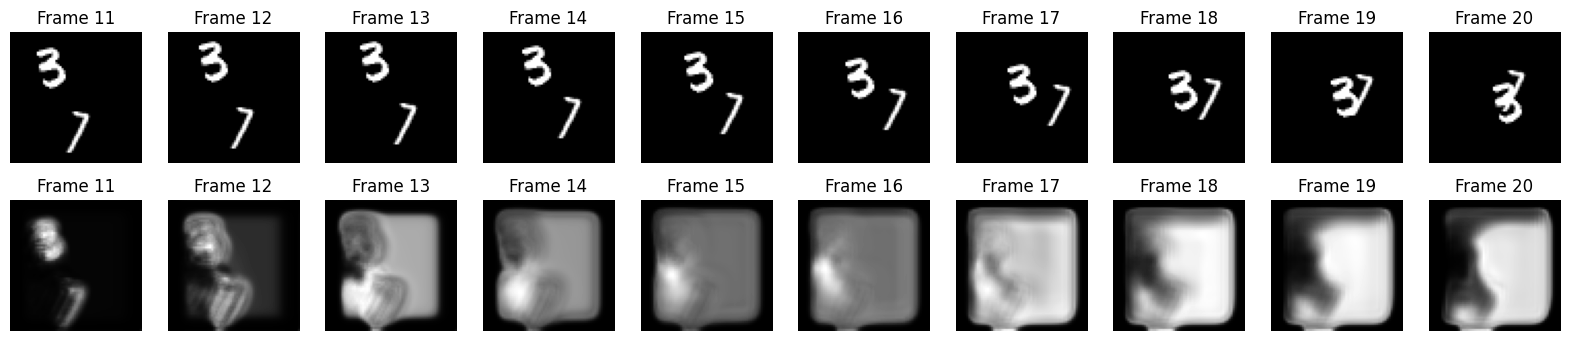

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
print("Example sample is: ",example.shape,np.random.choice(range(len(val_dataset)), size=1)[0])

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]
print("Input frames and original frames shapes are: ",frames.shape,original_frames.shape)

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    print("Output from prediction: ",new_prediction.shape,_)
    new_prediction = np.squeeze(new_prediction, axis=0)
    print("After squeezing from prediction: ",new_prediction.shape,_)

    # take the last one from new_prediction and concatenate to the input
    # frame to serve as a new input frame. Note that y is lagged by 1 relative
    # to x, i.e., x input from [0-9] corresponds to y output [1-10]. So the
    # new_prediction will be [1-10] similar to y. Taking the last slice [-1,...]
    # would mean the prediction at time t = 10, given input x frames from 0-9.
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    print("After expanding from prediction: ",predicted_frame.shape,_)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conv-lstm) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conv-lstm).

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 62ms/step
 Truth	Prediction
